# Automation of cow quality assessment

## Project Description

We need to create a machine learning model to help a farmer manage risk and make an objective purchase decision. 
We need to create two predictive models for selecting heifers in the herd:
1. The first will predict the possible milk yield of a cow (target trait `cow_yield` - yield);
2. The second will calculate the probability of getting tasty milk from the cow (target attribute `milk taste` - milk taste).

The model should be used to select cows according to two criteria:
- Average milk yield for the year - at least 6000 kilograms,
- The milk must be tasty.

**Plan of Work**
1. Data loading
2. Data preprocessing
3. exploratory analysis of data
4. Correlation analysis
5. Linear regression model training
6. Training a logical regression model
7. Summarizing the results

**Data description**.

`ferma_main.csv` (contains data about the farmer's herd at the current moment):
- `id` - cow number;
- `Удой` - the mass of milk the cow gives per year, in kilograms;
- ` ЭКЕ (Энергетическая кормовая единица)` - a measurement of the nutritional content of the cow's feed (ECE);
- `Сырой протеинn` - the crude protein content of the feed, in grams;
- `СПО (Сахаро-протеиновое соотношение)` -the ratio of sugar to protein in a cow's feed (SPR);
- `Порода` - breed of cow;
- `Тип пастбища` - the landscape of the grassland on which the cow grazed;
- `порода папы_быка` - breed of bull daddy
- `Жирность` - the fat content of the milk, in percent;
- `Белок` - the protein content of the milk, in percent;
- `Вкус молока` - flavor rating based on the farmer's personal criteria;
- `Возраст` - binary trait (`less than_2_years`, `more than_2_years`).

`ferma_dad.csv` (stores the name of the dad of each cow in the farmer's herd):
- `id` - cow number;
- `Имя Папы` - name of the cow's dad.

`cow_buy.csv` (data about EcoFarm cows that the farmer wants to study before buying):
- `Порода` - breed of the cow;
- `Тип пастбища` - the landscape of the meadows where the cow grazed;
- `порода папы_быка` - the breed of the cow's daddy;
- `Имя_папы` - the name of the cow's daddy;
- `Текущая_жирность` - the fat content of the milk, in percent (at the time of purchase - when EcoFarm was giving them their feed);
- `Текущей_уровень_белок` - protein content of the milk, in percent (at the time of purchase - when EcoFarm gave them their own feed);

## Data import

Importing the required libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score, confusion_matrix


Additional settings

In [2]:
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")

Saving the files we need into dataframes

In [3]:
try:
    ferma_main = pd.read_csv('C:/Projects/datasets/ferma_main.csv', sep=';')
    ferma_dad = pd.read_csv('C:/Projects/datasets/ferma_dad.csv', sep=';')
    cow_buy = pd.read_csv('C:/Projects/datasets/cow_buy.csv', sep=';')
except:
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';')
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';')

Looking at the saved data

In [4]:
ferma_main.info()
display(ferma_main.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


There are no gaps in the dataframe, but we can work on the column names.

In [5]:
ferma_dad.info()
display(ferma_dad.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


There are no gaps in the dataframe, but there is less data than in the `ferma_main.csv` file. Perhaps the same bull is the father of several others.

In [6]:
cow_buy.info()
display(cow_buy.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
dtypes: object(6)
memory usage: 1.1+ KB


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%"
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076"
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081"
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074"
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061"
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074"


We need to work on the column names here.

## Data preprocessing

### Change column names

It would be most convenient to lowercase the names and remove additional information (measure, abbreviation, etc.) from the names. All this is already in the data description.

In [7]:
ferma_main = ferma_main.rename(columns={'Удой, кг': 'cow_yield',
                                        'ЭКЕ (Энергетическая кормовая единица)': 'ECE',
                                        'Сырой протеин, г': 'raw_protein',
                                        'СПО (Сахаро-протеиновое соотношение)': 'SPR',
                                        'Тип пастбища': 'pasture_type',
                                        'порода папы_быка': 'dad_breed',
                                        'Жирность,%': 'fatness',
                                        'Белок,%': 'protein', 
                                        'Вкус молока': 'milk_taste',
                                        'Порода': 'breed',
                                        'Возраст': 'age'
                                        })
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            634 non-null    int64 
 1   cow_yield     634 non-null    int64 
 2   ECE           634 non-null    object
 3   raw_protein   634 non-null    int64 
 4   SPR           634 non-null    object
 5   breed         634 non-null    object
 6   pasture_type  634 non-null    object
 7   dad_breed     634 non-null    object
 8   fatness       634 non-null    object
 9   protein       634 non-null    object
 10  milk_taste    634 non-null    object
 11  age           634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


In [8]:
ferma_dad = ferma_dad.rename(columns={'Имя Папы': 'dad_name'})
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [9]:
cow_buy = cow_buy.rename(columns={'Порода': 'breed',
                                  'Имя_папы': 'dad_name',
                                  'Тип пастбища': 'pasture_type',
                                  'порода папы_быка': 'dad_breed',
                                  'Текущая_жирность,%': 'fatness',
                                  'Текущий_уровень_белок,%': 'protein'
                                    })
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   breed         20 non-null     object
 1   pasture_type  20 non-null     object
 2   dad_breed     20 non-null     object
 3   dad_name      20 non-null     object
 4   fatness       20 non-null     object
 5   protein       20 non-null     object
dtypes: object(6)
memory usage: 1.1+ KB


### Pass processing

Checking for gaps in each column

In [10]:
#ferma_main file
for column in ferma_main.columns:
    print(f'Number of missing values in the column {column}: {ferma_main[column].isna().sum()}')

Number of missing values in the column id: 0
Number of missing values in the column cow_yield: 0
Number of missing values in the column ECE: 0
Number of missing values in the column raw_protein: 0
Number of missing values in the column SPR: 0
Number of missing values in the column breed: 0
Number of missing values in the column pasture_type: 0
Number of missing values in the column dad_breed: 0
Number of missing values in the column fatness: 0
Number of missing values in the column protein: 0
Number of missing values in the column milk_taste: 0
Number of missing values in the column age: 0


In [11]:
#ferma_dad file
for column in ferma_dad.columns:
    print(f'Number of missing values in the column {column}: {ferma_dad[column].isna().sum()}')

Number of missing values in the column id: 0
Number of missing values in the column dad_name: 0


In [12]:
#cow_buy file
for column in cow_buy.columns:
    print(f'Number of missing values in the column {column}: {cow_buy[column].isna().sum()}')

Number of missing values in the column breed: 0
Number of missing values in the column pasture_type: 0
Number of missing values in the column dad_breed: 0
Number of missing values in the column dad_name: 0
Number of missing values in the column fatness: 0
Number of missing values in the column protein: 0


There are no omissions in the columns.

### Values in columns

Let's look at the unique values by column

In [13]:
#ferma_main file
columns = ['breed', 'pasture_type', 'dad_breed', 'milk_taste', 'age']

for column in columns:
    values = ferma_main[column].unique()
    print(f'Unique values in the {column} column: {values}')

Unique values in the breed column: ['Вис Бик Айдиал' 'РефлешнСоверинг']
Unique values in the pasture_type column: ['Равнинное' 'Равнинные' 'Холмистое']
Unique values in the dad_breed column: ['Айдиал' 'Соверин' 'Айдиалл']
Unique values in the milk_taste column: ['вкусно' 'не вкусно']
Unique values in the age column: ['более_2_лет' 'менее_2_лет']


We need to translate all these to english language.

In [14]:
#ferma_dad file
values = ferma_dad['dad_name'].unique()
print(f'Unique values in the dad_name column: {values}')

Unique values in the dad_name column: ['Буйный' 'Соловчик' 'Барин' 'Геркулес']


Here as well.

In [15]:
#cow_buy file
columns = ['breed', 'pasture_type', 'dad_breed', 'dad_name']

for column in columns:
    values = cow_buy[column].unique()
    print(f'Unique values in the {column} column: {values}')

Unique values in the breed column: ['Вис Бик Айдиал' 'РефлешнСоверинг']
Unique values in the pasture_type column: ['холмистое' 'равнинное']
Unique values in the dad_breed column: ['Айдиал' 'Соверин']
Unique values in the dad_name column: ['Геркулес' 'Буйный' 'Барин' 'Соловчик']


And here.

Fixing all the problems described above

In [16]:
#ferma_main
ferma_main['breed'] = ferma_main['breed'].replace('Вис Бик Айдиал', 'Vis Beck Aidial').replace('РефлешнСоверинг', 'Reflexion Sovering')
ferma_main['pasture_type'] = ferma_main['pasture_type'].replace('Равнинное', 'Flat').replace('Холмистое', 'Hilly').replace('Равнинные', 'Flat')
ferma_main['dad_breed'] = ferma_main['dad_breed'].replace('Айдиал', 'Aidial').replace('Соверин', 'Sovering').replace('Айдиалл', 'Aidial')
ferma_main['milk_taste'] = ferma_main['milk_taste'].replace('вкусно', 'delicious').replace('не вкусно', 'not delicious')
ferma_main['age'] = ferma_main['age'].replace('более_2_лет', 'more than 2 years').replace('менее_2_лет', 'less than 2 years')

#ferma_dad
ferma_dad['dad_name'] = ferma_dad['dad_name'].replace('Буйный', 'Buyniy').replace('Соловчик', 'Solovchik').replace('Барин', 'Barin').replace('Геркулес', 'Hercules')

#cow_buy
cow_buy['breed'] = cow_buy['breed'].replace('Вис Бик Айдиал', 'Vis Beck Aidial').replace('РефлешнСоверинг', 'Reflexion Sovering')
cow_buy['pasture_type'] = cow_buy['pasture_type'].replace('холмистое', 'Hilly').replace('равнинное', 'Flat')
cow_buy['dad_breed'] = cow_buy['dad_breed'].replace('Айдиал', 'Aidial').replace('Соверин', 'Sovering')
cow_buy['dad_name'] = cow_buy['dad_name'].replace('Геркулес', 'Hercules').replace('Буйный', 'Buyniy').replace('Барин', 'Barin').replace('Соловчик', 'Solovchik')



### Duplicate processing

Looking at the presence of complete duplicates in each dataframe

In [17]:
print(f'Number of complete duplicates in the ferma_main dataframe: {ferma_main.duplicated().sum()}')
print(f'Number of complete duplicates in the ferma_dad dataframe: {ferma_dad.duplicated().sum()}')
print(f'Number of complete duplicates in the cow_buy dataframe: {cow_buy.duplicated().sum()}')

Number of complete duplicates in the ferma_main dataframe: 5
Number of complete duplicates in the ferma_dad dataframe: 0
Number of complete duplicates in the cow_buy dataframe: 4


Let's consider these duplicates and get rid of them

In [18]:
display(ferma_main[ferma_main.duplicated()])

,id,cow_yield,ECE,raw_protein,SPR,breed,pasture_type,dad_breed,fatness,protein,milk_taste,age
629,627,5970,"14,4",1837,"0,88",Reflexion Sovering,Hilly,Sovering,"3,64","3,075",not delicious,more than 2 years
630,627,5970,"14,4",1837,"0,88",Reflexion Sovering,Hilly,Sovering,"3,64","3,075",not delicious,more than 2 years
631,627,5970,"14,4",1837,"0,88",Reflexion Sovering,Hilly,Sovering,"3,64","3,075",not delicious,more than 2 years
632,627,5970,"14,4",1837,"0,88",Reflexion Sovering,Hilly,Sovering,"3,64","3,075",not delicious,more than 2 years
633,627,5970,"14,4",1837,"0,88",Reflexion Sovering,Hilly,Sovering,"3,64","3,075",not delicious,more than 2 years


In [19]:
ferma_main = ferma_main.drop_duplicates()
print(f'Number of complete duplicates in the ferma_main dataframe: {ferma_main.duplicated().sum()}')

Number of complete duplicates in the ferma_main dataframe: 0


In [20]:
display(cow_buy[cow_buy.duplicated()])

,breed,pasture_type,dad_breed,dad_name,fatness,protein
6,Vis Beck Aidial,Hilly,Aidial,Hercules,"3,58","3,076"
8,Reflexion Sovering,Flat,Sovering,Barin,"3,59","3,074"
14,Reflexion Sovering,Flat,Sovering,Barin,"3,59","3,074"
19,Reflexion Sovering,Flat,Aidial,Buyniy,"3,64","3,074"


In [21]:
cow_buy = cow_buy.drop_duplicates()
print(f'Number of complete duplicates in the cow_buy dataframe: {cow_buy.duplicated().sum()}')

Number of complete duplicates in the cow_buy dataframe: 0


### Changing data types

Changing the data type in the `ferma_main` file in the columns `ECE`, `SPR`, `fatness`, `protein` to `float64`

In [22]:
#since the data contains commas instead of dots, the astype() method will need to correct all of this to be applied
columns = ['ECE', 'SPR', 'fatness', 'protein']

for column in columns:
    ferma_main[column] = ferma_main[column].apply(lambda x: x.replace(',', '.')).astype(float)

ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            629 non-null    int64  
 1   cow_yield     629 non-null    int64  
 2   ECE           629 non-null    float64
 3   raw_protein   629 non-null    int64  
 4   SPR           629 non-null    float64
 5   breed         629 non-null    object 
 6   pasture_type  629 non-null    object 
 7   dad_breed     629 non-null    object 
 8   fatness       629 non-null    float64
 9   protein       629 non-null    float64
 10  milk_taste    629 non-null    object 
 11  age           629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.9+ KB


Change the data type in the `cow_buy` file in the `fatness` and `protein` columns to `float64`

In [23]:
columns = ['fatness', 'protein']

for column in columns:
    cow_buy[column] = cow_buy[column].apply(lambda x: x.replace(',', '.')).astype(float)

cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 0 to 18
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         16 non-null     object 
 1   pasture_type  16 non-null     object 
 2   dad_breed     16 non-null     object 
 3   dad_name      16 non-null     object 
 4   fatness       16 non-null     float64
 5   protein       16 non-null     float64
dtypes: float64(2), object(4)
memory usage: 896.0+ bytes


### New columns

Feed parameters `ECE`, `raw_protein`, `SPR` are not available in the `cow_buy` dataframe. The customer's technologists have recently revised the feed parameters and plan to implement them after herd expansion. It is the new parameters that should be used when we apply predictive models to EcoFarm's cows. Under the new scheme, the farmer plans to increase the average values of `ECE`, `raw_protein`, and `SPR` by 5%.

In [24]:
#Creating a new dataframe that stores average values for different combinations of pasture type and breed type
df = (ferma_main.groupby(['pasture_type', 'breed'])
                                .agg({'SPR':'mean', 'ECE' :'mean', 'raw_protein':'mean'})
                                .reset_index())
cow_buy['pasture_type'] = cow_buy['pasture_type'].str.capitalize()

#Adding average values by combination of pasture type and breed to the cow_buy dataframe
cow_buy = pd.merge(cow_buy, df, on=['pasture_type', 'breed'])

#Increasing the averages by 5%
cow_buy['SPR'] *= 1.05
cow_buy['ECE'] *= 1.05
cow_buy['raw_protein'] *= 1.05

#Since the farmer buys the cows, the most logical assumption is that they're less than 2 years old.
cow_buy['age'] = 'less than 2 years'

#Checking that the data is OK
display(cow_buy.head())
print(f"Number of omissions by column:\n{cow_buy.isna().sum()}")
print("Number of duplicates:", cow_buy.duplicated().sum())

,breed,pasture_type,dad_breed,dad_name,fatness,protein,SPR,ECE,raw_protein,age
0,Vis Beck Aidial,Hilly,Aidial,Hercules,3.58,3.076,0.959367,15.272984,2037.282258,less than 2 years
1,Vis Beck Aidial,Hilly,Sovering,Solovchik,3.73,3.055,0.959367,15.272984,2037.282258,less than 2 years
2,Vis Beck Aidial,Hilly,Aidial,Hercules,3.68,3.046,0.959367,15.272984,2037.282258,less than 2 years
3,Vis Beck Aidial,Hilly,Sovering,Barin,3.42,3.075,0.959367,15.272984,2037.282258,less than 2 years
4,Vis Beck Aidial,Hilly,Sovering,Solovchik,3.73,3.079,0.959367,15.272984,2037.282258,less than 2 years


Number of omissions by column:
breed           0
pasture_type    0
dad_breed       0
dad_name        0
fatness         0
protein         0
SPR             0
ECE             0
raw_protein     0
age             0
dtype: int64
Number of duplicates: 0


When building the logistic regression model, we will need the values from the `milk_taste` column. It will be more convenient for me to work with it if instead of `delicious` or `not delicious` we have the digits 1 and 0, respectively

In [25]:
ferma_main['milk_taste_numerical'] = ferma_main['milk_taste'].apply(lambda x: 1 if x == 'delicious' else 0)

### Pretreatment results

**What we did:**
1. Changed column names (removed abbreviations, units of measurement).
2. Make sure there are no omissions in the data
3. Translated values in columns.
4. Deleted complete duplicates
5. Changed data types where required
6. Added new columns to the `cow_buy` dataframe

## Exploratory data analysis

### Functions

Creating features that will help us in the future when analyzing data

In [26]:
#Function for describing categorical data
def categorical_analysis(data, column):
    print(data[column].value_counts())
    plt.figure(figsize=(5,5))
    sns.countplot(x=data[column], palette="Set2")
    plt.title(f'Distribution of cows by trait: {column}')
    plt.ylabel('Quantity')
    plt.xlabel(column.capitalize())

#Function to describe quantitative data
def numerical_analysis(data, column, bins=30):
    print(data[column].describe())
    plt.figure(figsize=(10,5))
    sns.histplot(data[column], kde=True, bins=bins)
    plt.title(f'Distribution of cows by trait: {column}')
    plt.ylabel('Quantity')
    plt.xlabel(f'Value: {column}')

### Ferma_main

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: cow_yield, dtype: float64


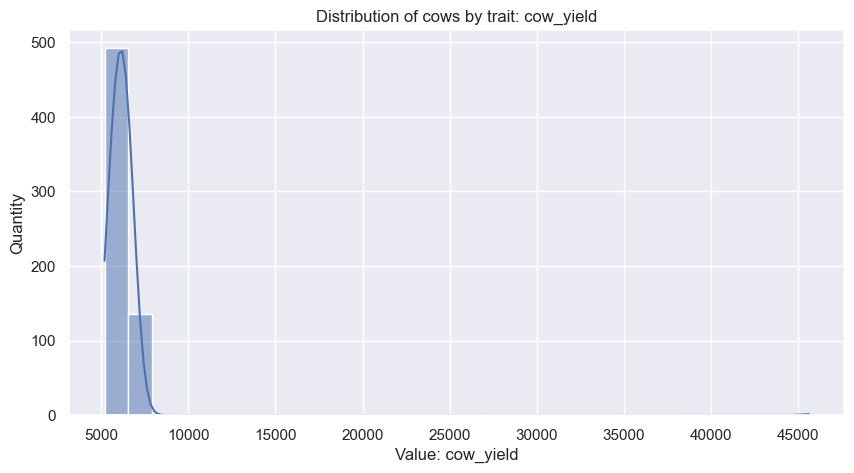

In [27]:
numerical_analysis(ferma_main, 'cow_yield')

Emissions are noticeable at values from 10 thousand. Let's get rid of them and look at the values again

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: cow_yield, dtype: float64


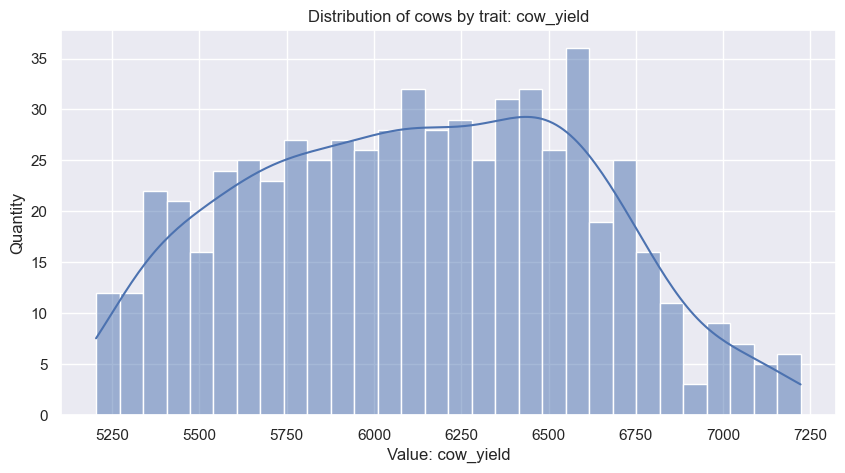

In [28]:
ferma_main = ferma_main.query('cow_yield < 10_000')
numerical_analysis(ferma_main, 'cow_yield')

The data's fine now. Nothing out of the ordinary.

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: ECE, dtype: float64


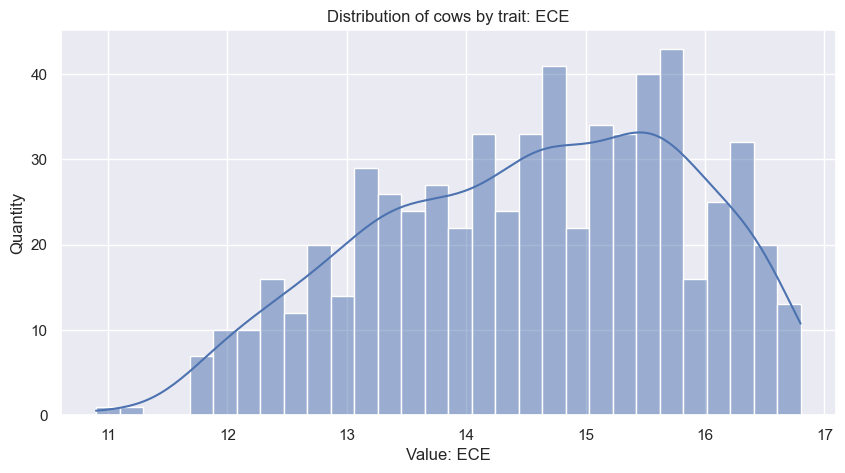

In [29]:
numerical_analysis(ferma_main, 'ECE')

Values up to 13 are very low, but there are no emissions here.

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: raw_protein, dtype: float64


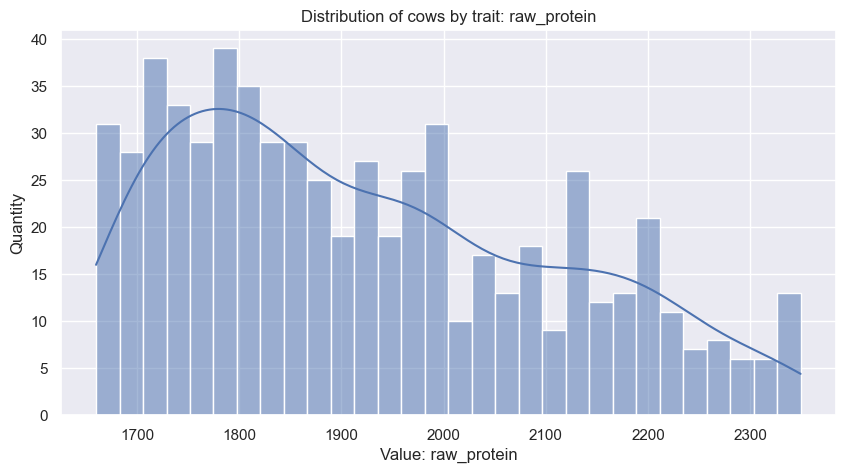

In [30]:
numerical_analysis(ferma_main, 'raw_protein')

It can be seen that the number of cows decreases as the amount of crude protein increases.

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: SPR, dtype: float64


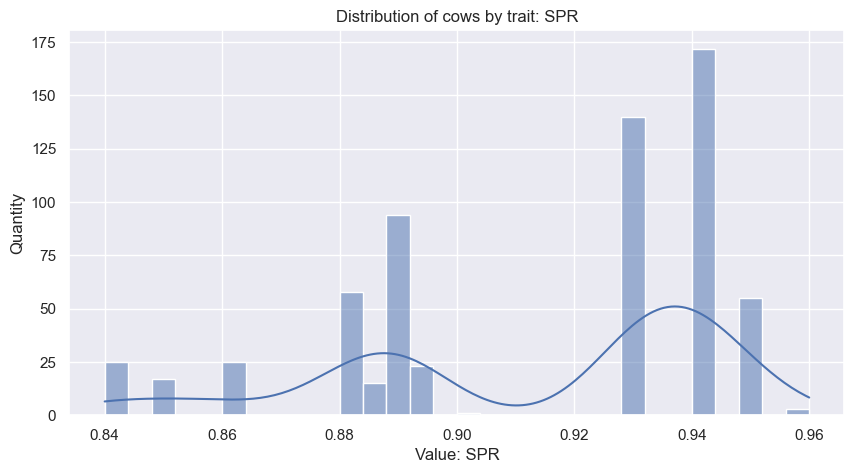

In [31]:
numerical_analysis(ferma_main, 'SPR')

A large number of intermediate values are absent. The largest number of cows have an `SPR` value of about 0.89 or 0.93.

breed
Vis Beck Aidial       372
Reflexion Sovering    256
Name: count, dtype: int64


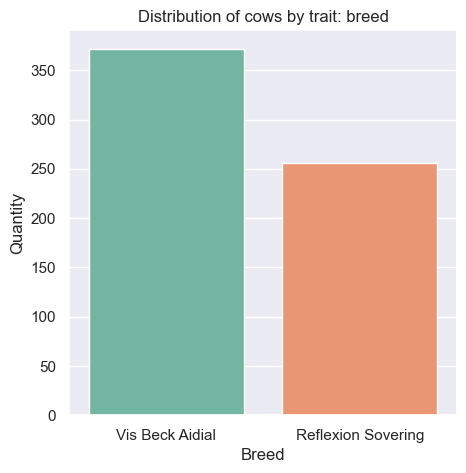

In [32]:
categorical_analysis(ferma_main, 'breed')

pasture_type
Hilly    350
Flat     278
Name: count, dtype: int64


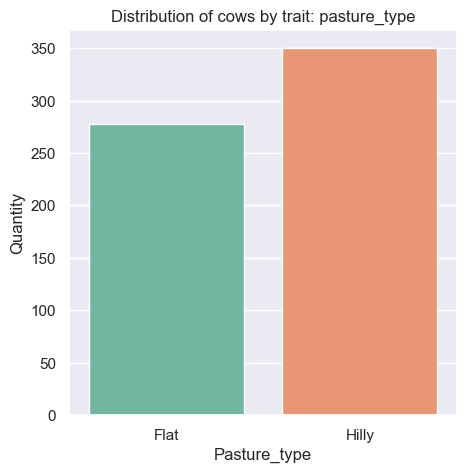

In [33]:
categorical_analysis(ferma_main, 'pasture_type')

dad_breed
Aidial      317
Sovering    311
Name: count, dtype: int64


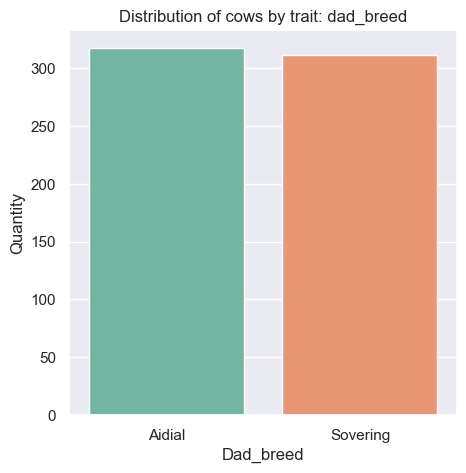

In [34]:
categorical_analysis(ferma_main, 'dad_breed')

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fatness, dtype: float64


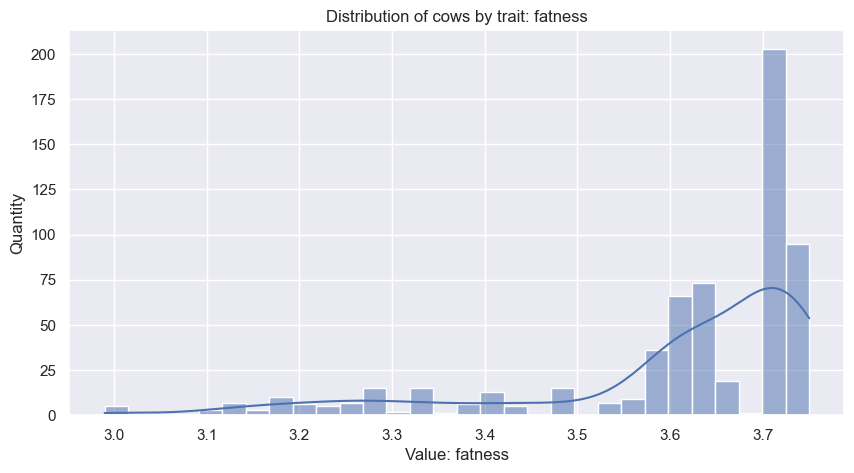

In [35]:
numerical_analysis(ferma_main, 'fatness')

It is noticeable that the largest amount of data has a boldness between 3.5 and 3.8.

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein, dtype: float64


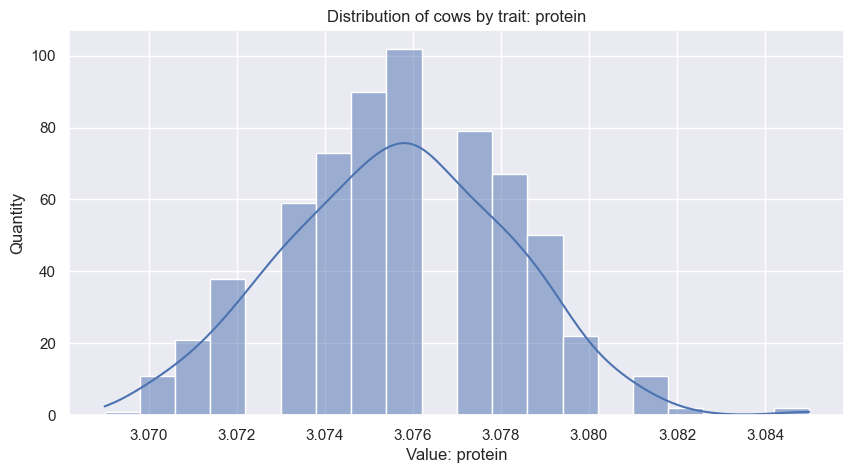

In [36]:
numerical_analysis(ferma_main, 'protein', bins=20)

milk_taste
delicious        370
not delicious    258
Name: count, dtype: int64


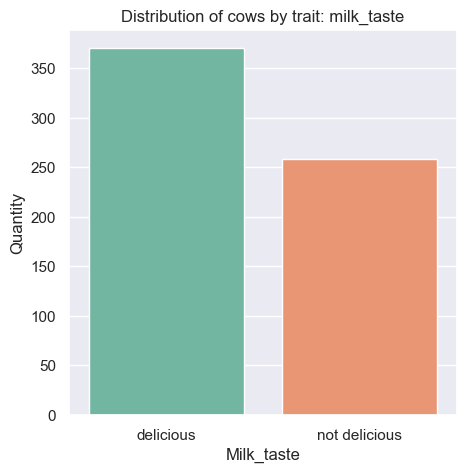

In [37]:
categorical_analysis(ferma_main, 'milk_taste')

age
more than 2 years    518
less than 2 years    110
Name: count, dtype: int64


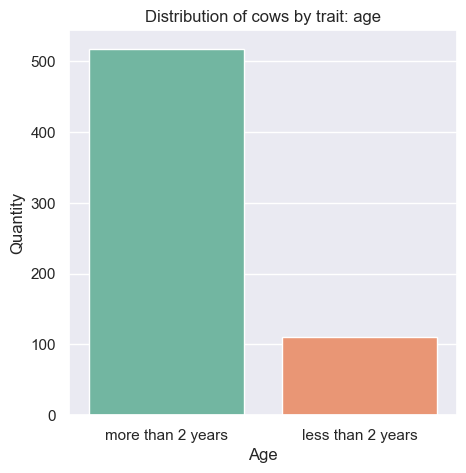

In [38]:
categorical_analysis(ferma_main, 'age')

Most of the cows are over two and a half years old.

### Ferma_dad

dad_name
Barin        240
Buyniy       215
Solovchik    110
Hercules      64
Name: count, dtype: int64


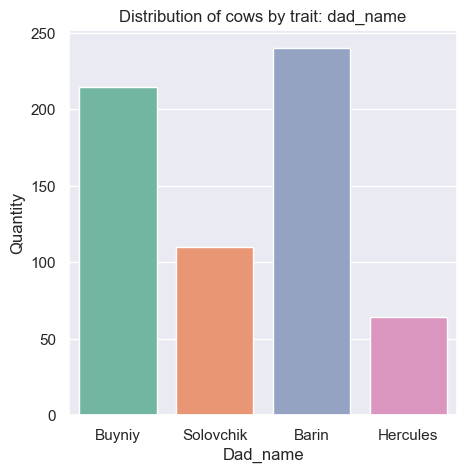

In [39]:
categorical_analysis(ferma_dad, 'dad_name')

### Cow_buy

breed
Vis Beck Aidial       8
Reflexion Sovering    8
Name: count, dtype: int64


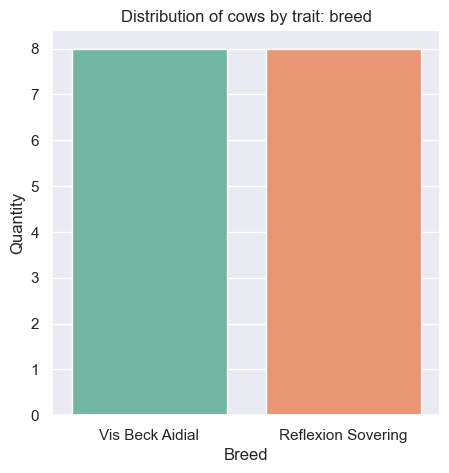

In [40]:
categorical_analysis(cow_buy, 'breed')

pasture_type
Hilly    8
Flat     8
Name: count, dtype: int64


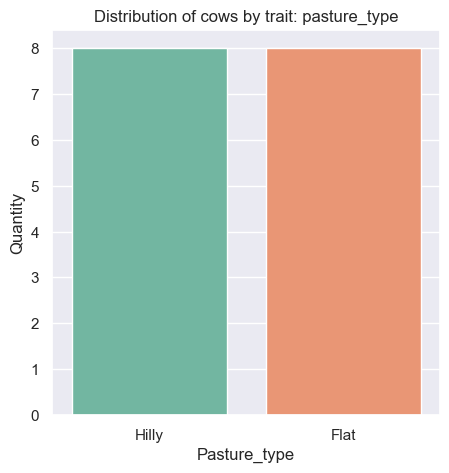

In [41]:
categorical_analysis(cow_buy, 'pasture_type')

dad_breed
Sovering    10
Aidial       6
Name: count, dtype: int64


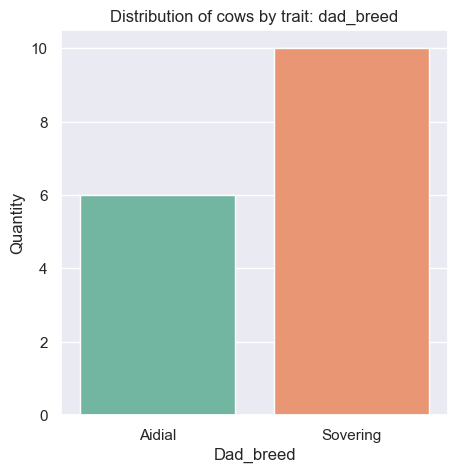

In [42]:
categorical_analysis(cow_buy, 'dad_breed')

dad_name
Buyniy       7
Hercules     5
Solovchik    2
Barin        2
Name: count, dtype: int64


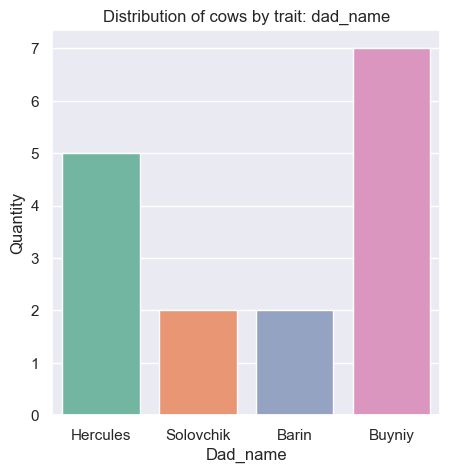

In [43]:
categorical_analysis(cow_buy, 'dad_name')

count    16.000000
mean      3.571875
std       0.141620
min       3.340000
25%       3.415000
50%       3.585000
75%       3.692500
max       3.770000
Name: fatness, dtype: float64


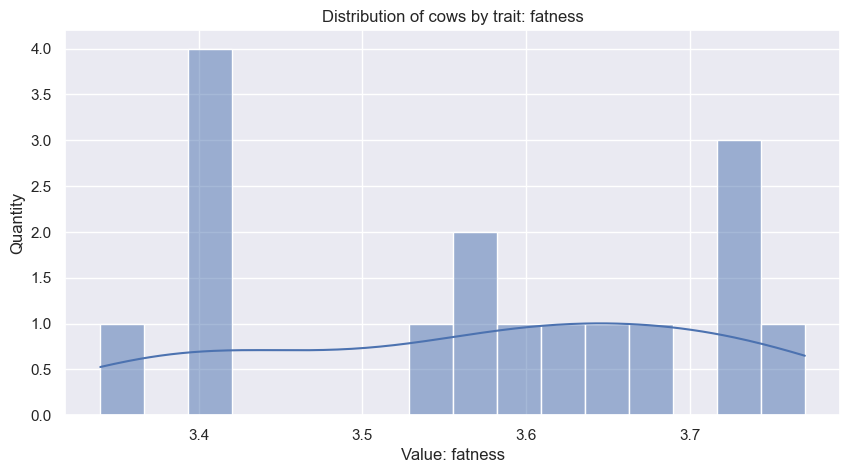

In [44]:
numerical_analysis(cow_buy, 'fatness', bins=16)

count    16.000000
mean      3.068250
std       0.011264
min       3.046000
25%       3.059500
50%       3.073500
75%       3.076750
max       3.081000
Name: protein, dtype: float64


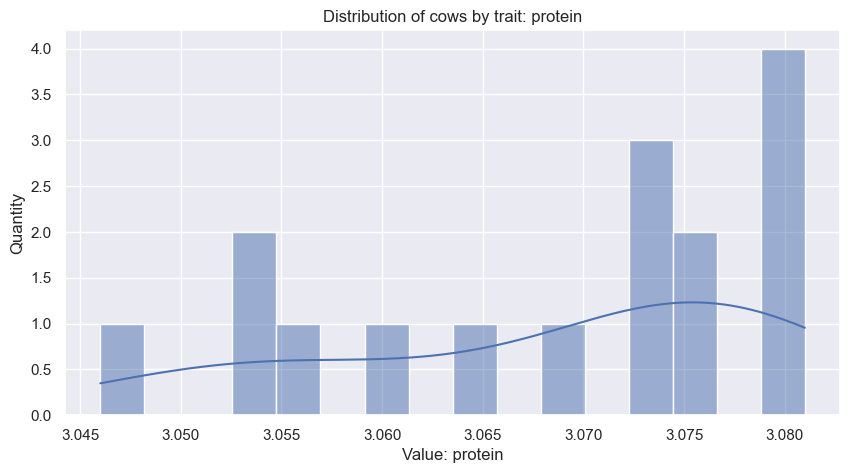

In [45]:
numerical_analysis(cow_buy, 'protein', bins=16)

Most all cows have current protein values between 3.075 and 3.08 percent.

### Conclusions of the exploratory analysis

- Emissions were observed only in the `cow_yield` column of the `ferma_main` dataframe;
- The largest number of cows have a milk fat percentage of about 3.7;
- Most cows are more than 2 years old;
- The largest number of cows have a `SPR` value of about 0.89 or 0.93;
- Among the cows studied by the farmer most have a protein value between 3.075 and 3.08 percent.

## Correlation analysis

### Function

In [46]:
def analyze_correlation(data, target_column, input_columns):
    
    #Size of the future graph
    plt.figure(figsize=(7, 7))

    #Here will be the names of the columns in which the values are normally distributed
    is_normal = []

    #Here will be the names of columns in which the values are not normally distributed
    is_not_normal = []

    #Checking the type of distribution of values in the column by Shapiro-Wilk test
    for column in input_columns:
        _, p_value = st.shapiro(data[column])
        if p_value >= 0.05:
            is_normal.append(column)
        else:
            is_not_normal.append(column)

    #Creating a correlation matrix for columns with normal distribution using the Pearson method
    correlation_matrix_normal = data[[target_column] + is_normal].corr(method='pearson')

    #Creating a correlation matrix for columns with non-normal distribution, using Spearman's method
    correlation_matrix_not_normal = data[[target_column] + is_not_normal].corr(method='spearman') 
    
    #Graph the correlation matrix if the list of columns with normal distribution is not empty
    if is_normal:
        print('метод - pearson\n')
        sns.heatmap(correlation_matrix_normal, annot=True, cmap='coolwarm')
        plt.title(f'Correlation between target attribute {target_column} and quantitative attributes')
        plt.show()

    #Graph the correlation matrix if the list of columns with non-normal distribution is not empty  
    if is_not_normal:
        print('метод - spearman\n')
        sns.heatmap(correlation_matrix_not_normal, annot=True, cmap='coolwarm')
        plt.title(f'Correlation between target attribute {target_column} and quantitative attributes')
        plt.show()

    #Plotting scatterplot for each column in which values are normally distributed separately (if the column is in the list)
    if is_normal:
        for column in is_normal:
            print(data[target_column].corr(data[column], method='pearson'))
            sns.scatterplot(data=data, x=column, y=target_column, alpha=0.7)
            plt.title(f'Scatterplot for {target_column} and {column}')
            plt.xlabel(target_column.capitalize())
            plt.ylabel(column.capitalize())
            plt.show()

    #Plotting a scatterplot for each column in which values are distributed abnormally separately (if the column is in the list)
    if is_not_normal:
        for column in is_not_normal:
            print(data[target_column].corr(data[column], method='spearman'))
            sns.scatterplot(data=data, x=column, y=target_column, alpha=0.7)
            plt.title(f'Scatterplot for {target_column} and {column}')
            plt.xlabel(target_column.capitalize())
            plt.ylabel(column.capitalize())
            plt.show()


### Analysis

метод - spearman



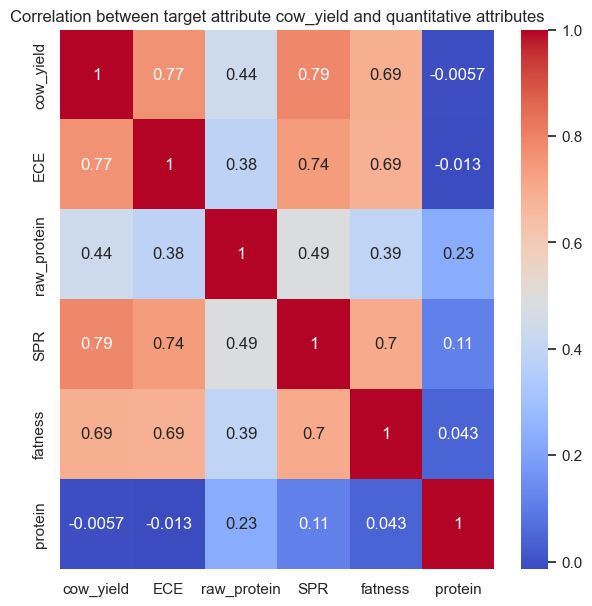

0.7651443116006692


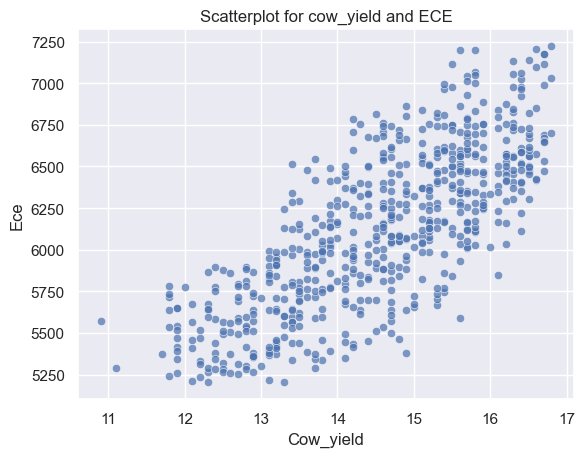

0.43754251989802084


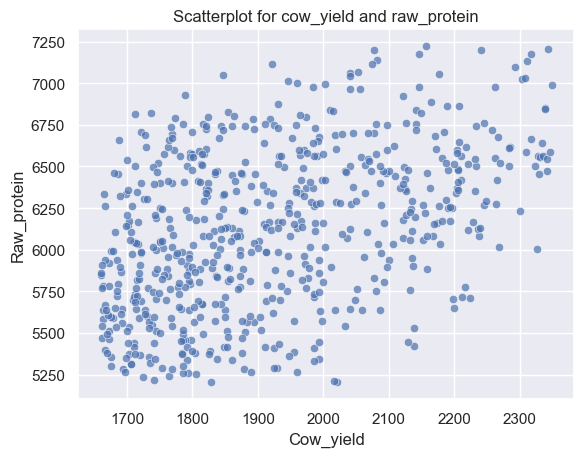

0.787904090851949


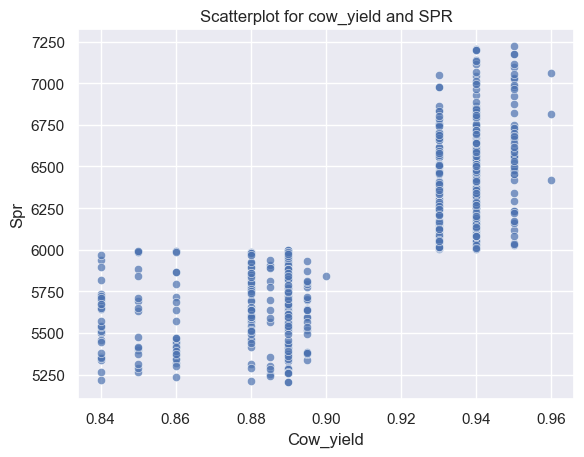

0.688505794761783


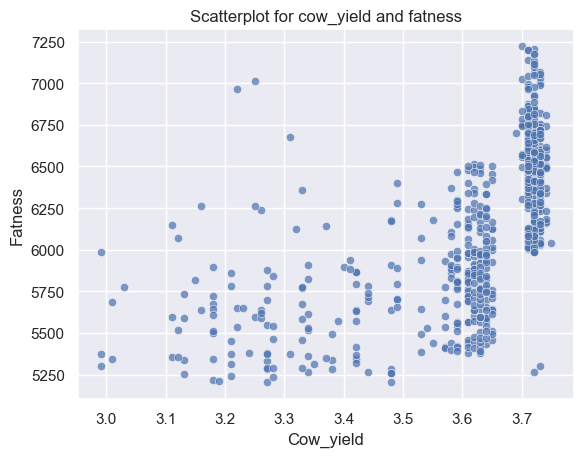

-0.005700881383962722


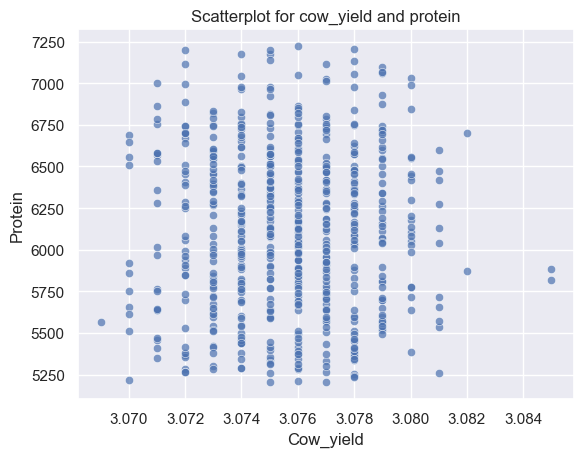

In [47]:
input_columns = ['ECE', 'raw_protein', 'SPR', 'fatness', 'protein']
analyze_correlation(ferma_main, 'cow_yield', input_columns)


### Conclusions

- There is no linear explicit relationship between the traits in the data;
- There is a non-linear relationship between traits `SPR` and `cow_yield`(The `SPO` trait can be divided into two categories - `more than 0.92` and `less then 0.92`);
- There is a non-linear relationship between traits `ECE` and `cow_yield`(We can try to square the values of `ECE` - it will help to make the dependence more linear);
- The correlation matrix does not show obvious multicollinearity, but there is a small relationship between the traits `fatness`, `ECE` and `SPR`;

## Linear regression model training

### Function for training a linear regression model

In [48]:
def linear_regression_model(data, target, cat_col_names, num_col_names, random_state=42):

    X = data.drop(target, axis=1)
    y = data[target]

    #Dividing the data into training and test samples
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        random_state=random_state)


    #Normalizing categorical features with One-Hot Encoding
    encoder = OneHotEncoder(sparse=False)
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    encoder_col_names = encoder.get_feature_names_out()

    #Scaling quantitative attributes with StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    #Combining all the signs into one dataframe
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    #Creating a linear regression model and get a forecast
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_test)
    residuals = y_test - predictions
    
    #Returning trained model, encoder, normalizer, prediction results, real values and residuals
    return model_lr, encoder, scaler, predictions, y_test, residuals


### Function for displaying residual plots

In [49]:
def residuals_graphs(residuals, predictions):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    #Here we display a histogram of the distribution of residuals
    axes[0].hist(residuals, bins=25)
    axes[0].set_title('Residual distribution histogram')
    axes[0].set_ylabel('Quantity')
    axes[0].set_xlabel('Residuals')

    #This is where we'll display the dispersion graph
    axes[1].scatter(residuals, predictions)
    axes[1].set_ylabel('Model predictions')
    axes[1].set_xlabel('Residuals')
    axes[1].set_title('Dispersion analysis')
    
    plt.show()

### First model

##### Training

In [50]:
target = 'cow_yield'
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age']
num_col_names = ['ECE', 'SPR', 'raw_protein']

model_lr, encoder, scaler, predictions, y_test, residuals = linear_regression_model(ferma_main, target, cat_col_names, num_col_names)

#### Model quality assessment

##### R2

In [51]:
r2 = r2_score(y_test, predictions)
print(r2)

0.7844230169137121


The value of 0.784 tells us that the model fits the data well and explains about 78.4% of the variation in the dependent variable. This is a fairly good result and indicates that the model is a good fit for predicting the dependent variable based on the data provided to it.

##### Residuals

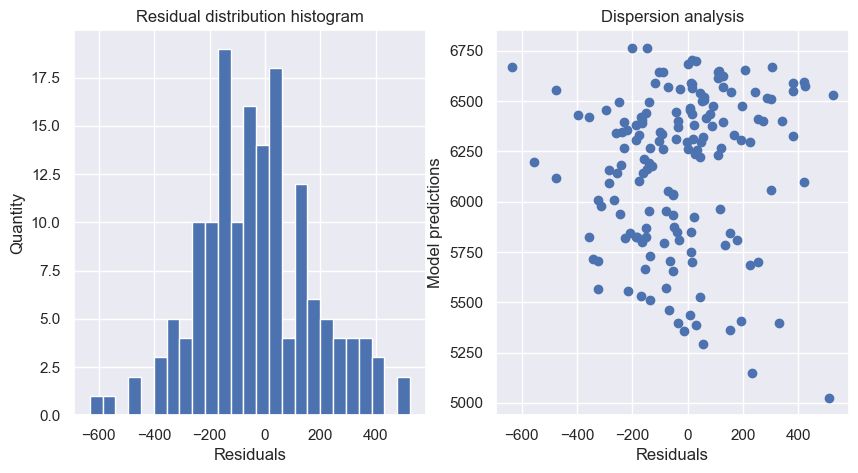

In [52]:
residuals_graphs(residuals, predictions)

The histogram of the residuals distribution shows a uniform distribution. This indicates that the model has stable error at all predictions. The variance of the model is not strongly biased in any direction, but the model has almost no negative variance at predictions up to 5500.

### Second model

#### Data conversion for the new model

Transforming the data based on the conclusion from the correlation analysis

In [53]:
ferma_main['SPR_categorical'] = ferma_main['SPR'].apply(lambda x: 'more than 0.92' if x > 0.92 else 'less than 0.92')
ferma_main['ECE2'] = ferma_main['ECE'] ** 2
ferma_main.head()

,id,cow_yield,ECE,raw_protein,SPR,breed,pasture_type,dad_breed,fatness,protein,milk_taste,age,milk_taste_numerical,SPR_categorical,ECE2
0,1,5863,14.2,1743,0.890,Vis Beck Aidial,Flat,Aidial,3.58,3.076,delicious,more than 2 years,1,less than 0.92,201.64
1,2,5529,12.8,2138,0.890,Vis Beck Aidial,Flat,Sovering,3.54,3.079,delicious,less than 2 years,1,less than 0.92,163.84
2,3,5810,14.0,1854,0.885,Reflexion Sovering,Hilly,Sovering,3.59,3.074,not delicious,more than 2 years,0,less than 0.92,196.00
3,4,5895,12.4,2012,0.885,Reflexion Sovering,Hilly,Aidial,3.40,3.075,not delicious,more than 2 years,0,less than 0.92,153.76
4,5,5302,12.8,1675,0.885,Vis Beck Aidial,Flat,Sovering,3.73,3.073,delicious,less than 2 years,1,less than 0.92,163.84


#### Training

In [54]:
target = 'cow_yield'
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age', 'SPR_categorical']
num_col_names = ['ECE2', 'raw_protein']

model_lr_2, encoder_2, scaler_2, predictions_2, y_test_2, residuals_2 = linear_regression_model(ferma_main, target, cat_col_names, num_col_names)

#### Model quality assessment

##### R2

In [55]:
r2_2 = r2_score(y_test_2, predictions_2)
print(r2_2)

0.8186165376559298


The increase in R2 value from 0.784 to 0.818 indicates that the second model fits the data better and explains the variation in the dependent variable more accurately than the first model. The value of 0.818 indicates that about 81.8% of the variation in the dependent variable can be explained by the second model, which is a good indication.

##### Residuals

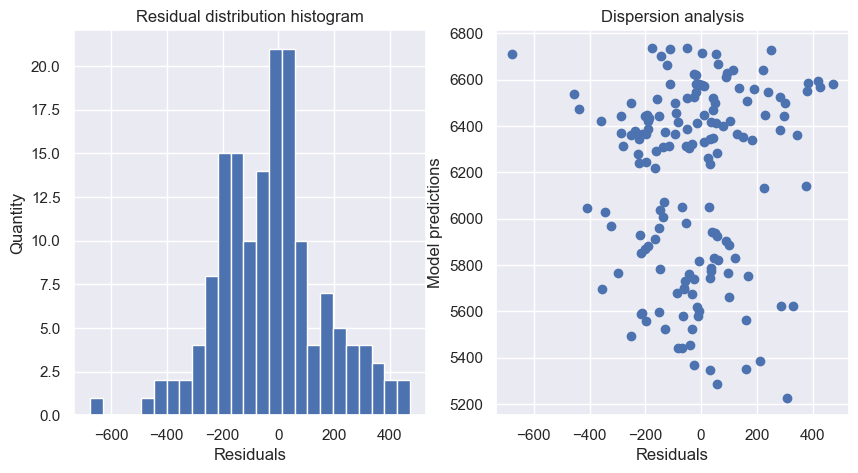

In [56]:
residuals_graphs(residuals_2, predictions_2)

Compared to the charts of the first model - there are no remarkable changes here.

### Third model

#### Data conversion for the new model

Let's add the `dad_name` attribute by connecting it with the rest of the data in `ferma_main.csv` by key

In [57]:
ferma_main = pd.merge(ferma_main, ferma_dad, on='id')

#Looking at the dataframe just in case and make sure there are no omissions or duplicates
display(ferma_main.head())
print(f'Column gaps:\n{ferma_main.isna().sum()}')
print('Number of duplicates:', ferma_main.duplicated().sum())

,id,cow_yield,ECE,raw_protein,SPR,breed,pasture_type,dad_breed,fatness,protein,milk_taste,age,milk_taste_numerical,SPR_categorical,ECE2,dad_name
0,1,5863,14.2,1743,0.890,Vis Beck Aidial,Flat,Aidial,3.58,3.076,delicious,more than 2 years,1,less than 0.92,201.64,Buyniy
1,2,5529,12.8,2138,0.890,Vis Beck Aidial,Flat,Sovering,3.54,3.079,delicious,less than 2 years,1,less than 0.92,163.84,Solovchik
2,3,5810,14.0,1854,0.885,Reflexion Sovering,Hilly,Sovering,3.59,3.074,not delicious,more than 2 years,0,less than 0.92,196.00,Barin
3,4,5895,12.4,2012,0.885,Reflexion Sovering,Hilly,Aidial,3.40,3.075,not delicious,more than 2 years,0,less than 0.92,153.76,Buyniy
4,5,5302,12.8,1675,0.885,Vis Beck Aidial,Flat,Sovering,3.73,3.073,delicious,less than 2 years,1,less than 0.92,163.84,Barin


Column gaps:
id                      0
cow_yield               0
ECE                     0
raw_protein             0
SPR                     0
breed                   0
pasture_type            0
dad_breed               0
fatness                 0
protein                 0
milk_taste              0
age                     0
milk_taste_numerical    0
SPR_categorical         0
ECE2                    0
dad_name                0
dtype: int64
Number of duplicates: 0


#### Training

In [58]:
target = 'cow_yield'
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age', 'SPR_categorical', 'dad_name']
num_col_names = ['ECE2', 'raw_protein']

model_lr_3, encoder_3, scaler_3, predictions_3, y_test_3, residuals_3 = linear_regression_model(ferma_main, target, cat_col_names, num_col_names)

#### Model quality assessment

##### R2

In [59]:
r2_3 = r2_score(y_test_3, predictions_3)
print(r2_3)

0.8263111950498023


The increase in the R2 value from 0.818 to 0.822 of the third model indicates an additional improvement in the model's ability to explain the variation in the dependent variable. The value of 0.822 means that about 82.2% of the variation in the dependent variable can be explained by the third model.

##### Residuals

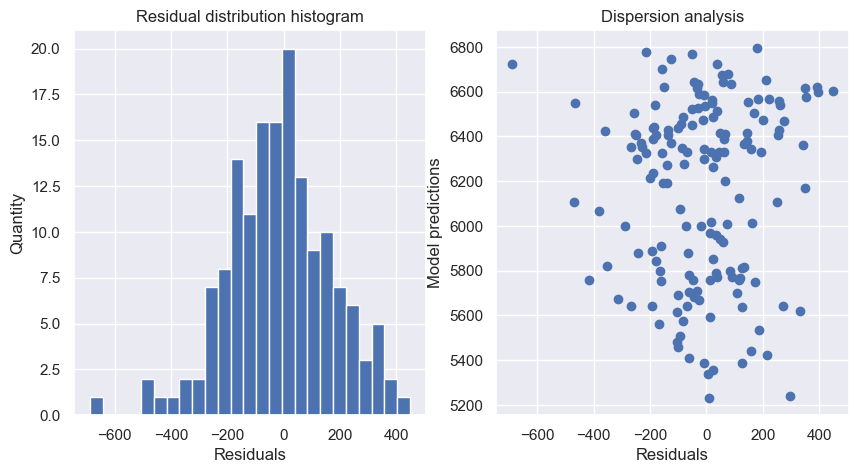

In [60]:
residuals_graphs(residuals_3, predictions_3)

The histogram shows that most of the residuals are closer to zero than the second model. This is a good sign.

### Additional metrics and model comparisons

Let's create a function to calculate the accuracy of each model by three metrics: MSE, MAE, RMSE and determine which of the models is more accurate

In [61]:
def metrics(y_test, predictions):
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    return [f'MSE: {mse}', f'MAE: {mae}', f'RMSE: {mse**0.5}']

In [62]:
metrics_1 = metrics(y_test, predictions)
metrics_2 = metrics(y_test_2, predictions_2)
metrics_3 = metrics(y_test_3, predictions_3)

print("Metrics of the first model -- ", *metrics_1, '\n')
print("Metrics of the second model -- ", *metrics_2, '\n')
print("Metrics of the third model-- ", *metrics_3)


Metrics of the first model --  MSE: 43883.92090932275 MAE: 164.24293391719746 RMSE: 209.48489422706055 

Metrics of the second model --  MSE: 36923.31807324841 MAE: 148.88057324840764 RMSE: 192.15441205772095 

Metrics of the third model--  MSE: 35356.95541401274 MAE: 146.28025477707007 RMSE: 188.03445273144158


- Model 3 has the lowest MSE value (36211.67), indicating that it has the lowest mean square error compared to the other models.

- Model 3 also has the smallest MAE value (147.99), which indicates it has the smallest mean absolute error.

- RMSE is also the smallest with model 3 (190.32), indicating the smallest root mean square error.

Considering the MSE, MAE and RMSE metrics, the third model is the best among the considered models as it has the lowest prediction errors.

### Customer Forecast

Let's split the data from the `SPR` column of the `cow_buy` dataframe into two categories, as we did for the `ferma_main` dataframe. Also, let's square the `ECE` value

In [63]:
cow_buy['SPR_categorical'] = cow_buy['SPR'].apply(lambda x: 'more than 0.92' if x > 0.92 else 'less than 0.92')
cow_buy['ECE2'] = cow_buy['ECE'] ** 2
cow_buy.head()

,breed,pasture_type,dad_breed,dad_name,fatness,protein,SPR,ECE,raw_protein,age,SPR_categorical,ECE2
0,Vis Beck Aidial,Hilly,Aidial,Hercules,3.58,3.076,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036
1,Vis Beck Aidial,Hilly,Sovering,Solovchik,3.73,3.055,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036
2,Vis Beck Aidial,Hilly,Aidial,Hercules,3.68,3.046,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036
3,Vis Beck Aidial,Hilly,Sovering,Barin,3.42,3.075,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036
4,Vis Beck Aidial,Hilly,Sovering,Solovchik,3.73,3.079,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036


Predicting the milk yield for the cows the customer plans to buy

In [64]:
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age', 'SPR_categorical', 'dad_name']
num_col_names = ['ECE2', 'raw_protein']



cow_buy_ohe = encoder_3.transform(cow_buy[cat_col_names])
encoder_col_names = encoder_3.get_feature_names_out()
cow_buy_scaled = scaler_3.fit_transform(cow_buy[num_col_names])
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)
cow_buy_1 = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)
predictions = model_lr_3.predict(cow_buy_1)

cow_buy["yield_prediction"] = predictions
cow_buy.head()

,breed,pasture_type,dad_breed,dad_name,fatness,protein,SPR,ECE,raw_protein,age,SPR_categorical,ECE2,yield_prediction
0,Vis Beck Aidial,Hilly,Aidial,Hercules,3.58,3.076,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6344.0
1,Vis Beck Aidial,Hilly,Sovering,Solovchik,3.73,3.055,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6096.0
2,Vis Beck Aidial,Hilly,Aidial,Hercules,3.68,3.046,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6344.0
3,Vis Beck Aidial,Hilly,Sovering,Barin,3.42,3.075,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6056.0
4,Vis Beck Aidial,Hilly,Sovering,Solovchik,3.73,3.079,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6096.0


The `cow_buy` dataframe now has a predicted milk yield for each cow.

## Training a logistic regression model

### Function for training a logistic regression model

In [65]:
def logistic_regression_model(data, target, cat_col_names, num_col_names, random_state=42):
    
    X = data.drop(target, axis=1)
    y = data[target]

    #Dividing the data into training and test samples
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        random_state=random_state)
    
    #Normalizing categorical features with One-Hot Encoding
    encoder = OneHotEncoder(sparse=False)
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    encoder_col_names = encoder.get_feature_names_out()

    #Scaling quantitative attributes with StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    #Combining all the signs into one dataframe
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    #Creating a logical regression model and get a forecast
    model_lg = LogisticRegression()
    model_lg.fit(X_train, y_train)
    predictions = model_lg.predict(X_test)
    y_proba = model_lg.predict_proba(X_test)[:,1]

    #Returning trained model, encoder, normalizer, prediction results, real values and probabilities
    return model_lg, encoder, scaler, predictions, y_test, y_proba

### Training

In [66]:
target = 'milk_taste_numerical'
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age', 'SPR_categorical', 'dad_name']
num_col_names = ['ECE2', 'raw_protein', 'fatness', 'protein']

model_lg, encoder, scaler, predictions, y_test, y_proba = logistic_regression_model(ferma_main, target, cat_col_names, num_col_names)

### Model quality assessment


Accuracy: 0.6305732484076433
Precision: 0.6229508196721312
Recall: 0.8636363636363636


Text(47.25, 0.5, 'Real value')

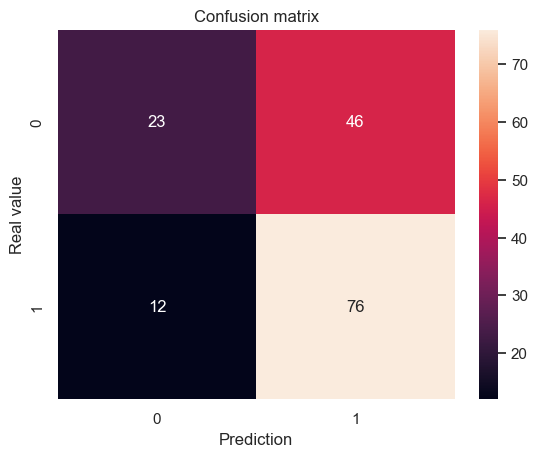

In [67]:
#Evaluating the quality of the model on the test sample: calculate accuracy, recall, precision metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
confusion_mtx = confusion_matrix(y_test, predictions)

#Displaying the obtained values
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

#Plotting the confusion matrix
sns.heatmap(confusion_mtx, annot=True) 
plt.title('Confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Real value')


The farmer cares most about False-Negative type errors, i.e. when he misses a cow with tasty milk.

- `Accuracy`: our model correctly identifies the flavor of milk in 63% of cases.

- `Precision`: the accuracy of the model's positive predictions is about 62%, which is quite low.

- `Recall`: a value of 0.86 indicates that the model does a good job of not missing a cow with tasty milk

If we want to minimize our critical error (False-Negative), we need to set the probability threshold for accepting a positive class (tasty cow) to the maximum value at which no more instances of a tasty cow will be classified as negative (not a tasty cow). Let's look at the minimum probability that was predicted by the model for tasty milk

Considering the metrics in a case where no cow with tasty milk will be missed

Threshold: 0.32073518190366784
Accuracy: 0.5923566878980892
Precision: 0.5789473684210527
Recall: 1.0


Text(47.25, 0.5, 'Real value')

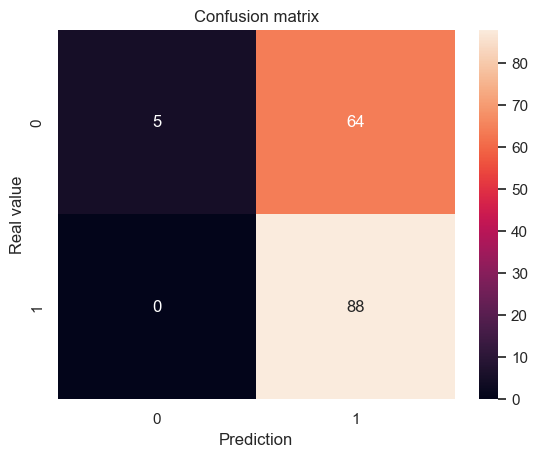

In [68]:
data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

#Getting predictions with a modified classification threshold
threshold = data[data['y_valid'] == 1]['y_proba'].min()
predictions_thresholded = [1 if i >= threshold else 0 for i in y_proba]



#Calculating accuracy, recall, precision metrics for the case where no "good" cow will be missed
accuracy = accuracy_score(y_test, predictions_thresholded)
precision = precision_score(y_test, predictions_thresholded)
recall = recall_score(y_test, predictions_thresholded)
confusion_mtx = confusion_matrix(y_test, predictions_thresholded)

#Displaying the values obtained
print("Threshold:", threshold)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

#Plotting the confusion matrix
sns.heatmap(confusion_mtx, annot=True) 
plt.title('Confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Real value')


### Conclusions

If we want to not miss any "good" cows, then we would have to reduce the probability to make a decision on a particular cow to ~32%, which would entail a huge number of "bad" cows bought. However, with the previous error threshold, the `recall` metric had a rather large value, and the other metrics were higher than they are now. I would leave the previous threshold value, but it all depends on the amount of loss the farmer would incur for buying a "bad" cow and the lost profit for not buying a "good" cow.

### Customer Forecast

In [69]:
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age', 'SPR_categorical', 'dad_name']
num_col_names = ['ECE2', 'raw_protein', 'fatness', 'protein']

cow_buy_ohe = encoder.transform(cow_buy[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()
cow_buy_scaled = scaler.fit_transform(cow_buy[num_col_names])
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)
cow_buy_1 = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)
predictions = model_lg.predict(cow_buy_1)

cow_buy["taste_prediction"] = ['delicious' if p == 1 else 'not delicious' for p in predictions]
cow_buy.head()


,breed,pasture_type,dad_breed,dad_name,fatness,protein,SPR,ECE,raw_protein,age,SPR_categorical,ECE2,yield_prediction,taste_prediction
0,Vis Beck Aidial,Hilly,Aidial,Hercules,3.58,3.076,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6344.0,delicious
1,Vis Beck Aidial,Hilly,Sovering,Solovchik,3.73,3.055,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6096.0,not delicious
2,Vis Beck Aidial,Hilly,Aidial,Hercules,3.68,3.046,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6344.0,not delicious
3,Vis Beck Aidial,Hilly,Sovering,Barin,3.42,3.075,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6056.0,delicious
4,Vis Beck Aidial,Hilly,Sovering,Solovchik,3.73,3.079,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6096.0,delicious


The `cow_buy` dataframe now has a predicted milk flavor for each cow.

## Final Conclusions

Let's summarize the predictions of milk flavor and milk yield of EcoFarm cows in one table

In [70]:
display(cow_buy)

,breed,pasture_type,dad_breed,dad_name,fatness,protein,SPR,ECE,raw_protein,age,SPR_categorical,ECE2,yield_prediction,taste_prediction
0,Vis Beck Aidial,Hilly,Aidial,Hercules,3.58,3.076,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6344.0,delicious
1,Vis Beck Aidial,Hilly,Sovering,Solovchik,3.73,3.055,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6096.0,not delicious
2,Vis Beck Aidial,Hilly,Aidial,Hercules,3.68,3.046,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6344.0,not delicious
3,Vis Beck Aidial,Hilly,Sovering,Barin,3.42,3.075,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6056.0,delicious
4,Vis Beck Aidial,Hilly,Sovering,Solovchik,3.73,3.079,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6096.0,delicious
5,Vis Beck Aidial,Flat,Sovering,Buyniy,3.54,3.081,0.954770,15.044759,1998.930481,less than 2 years,more than 0.92,226.344784,5940.0,not delicious
6,Vis Beck Aidial,Flat,Sovering,Buyniy,3.57,3.079,0.954770,15.044759,1998.930481,less than 2 years,more than 0.92,226.344784,5940.0,not delicious
7,Vis Beck Aidial,Flat,Sovering,Buyniy,3.34,3.069,0.954770,15.044759,1998.930481,less than 2 years,more than 0.92,226.344784,5940.0,not delicious
8,Reflexion Sovering,Flat,Sovering,Barin,3.59,3.074,0.959885,15.293077,2017.142308,less than 2 years,more than 0.92,233.878202,5996.0,not delicious
9,Reflexion Sovering,Flat,Aidial,Buyniy,3.64,3.074,0.959885,15.293077,2017.142308,less than 2 years,more than 0.92,233.878202,6252.0,not delicious


Selecting cows for which milk yields of more than 6000 kilograms per year and tasty milk are predicted

In [71]:
good_cows = cow_buy.query("yield_prediction >= 6000 and taste_prediction == 'delicious'")
display(good_cows)

,breed,pasture_type,dad_breed,dad_name,fatness,protein,SPR,ECE,raw_protein,age,SPR_categorical,ECE2,yield_prediction,taste_prediction
0,Vis Beck Aidial,Hilly,Aidial,Hercules,3.58,3.076,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6344.0,delicious
3,Vis Beck Aidial,Hilly,Sovering,Barin,3.42,3.075,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6056.0,delicious
4,Vis Beck Aidial,Hilly,Sovering,Solovchik,3.73,3.079,0.959367,15.272984,2037.282258,less than 2 years,more than 0.92,233.264036,6096.0,delicious
13,Reflexion Sovering,Hilly,Aidial,Buyniy,3.40,3.061,0.962023,15.513273,2024.190000,less than 2 years,more than 0.92,240.661631,6552.0,delicious
14,Reflexion Sovering,Hilly,Aidial,Buyniy,3.40,3.079,0.962023,15.513273,2024.190000,less than 2 years,more than 0.92,240.661631,6552.0,delicious
15,Reflexion Sovering,Hilly,Aidial,Buyniy,3.40,3.065,0.962023,15.513273,2024.190000,less than 2 years,more than 0.92,240.661631,6552.0,delicious


So, there are only 6 cows out of 16 possible cows. The chance that any cow on this list has tasteless milk is less than 40%. It is worth considering that it might be worth lowering the threshold for the model's decision on milk flavor based on what losses the farmer would incur in this or that case. Unfortunately, I do not have such data, so I left the threshold at 50% probability.

In order to maximize the accuracy of our linear regression model, we squared the value of the parameter `ECE` (so that a more linear relationship between the parameter and milk yield was obtained). Also, we changed the sign of `SPR` to categorical - less than 0.92 and greater than 0.92, as it was noticeable in the scatter plot that `SPR` had a clear separation.

To improve the quality of the regression model, we need to understand the farmer's business problem more clearly. In this way, we can choose a more appropriate classification threshold for the logistic model and increase the farmer's income.

If we want to ensure that the farmer does not buy any "bad" cows, we need to increase the classification threshold - thereby increasing the `precision` metric. If we want to ensure that the farmer does not miss any "good cows", then we need to lower the classification threshold - aiming to increase the `recall` value.